# Mario: Basic Tasks 

#### Goal: Mario pick-up ladder, go to princess(goal) and avoid Bowser(obstacle) in 6x6 grid

1. Environment definition
2. State and Reward function
3. Q-learning update rule and policy (epsilon greedy and softmax)
4. Run and measure performance for one episode, 10, 50, 100


* observation_space = state space as the grid is a fully observable environment 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gym
from gym import Env, logger, spaces, utils
import random
from enum import Enum
import pandas as pd

In [ ]:
# The Warehouse is divided into a grid. Use these 'tiles' to represent the objects on the grid.
class GridTile(Enum):
    _Floor = 0
    Mario = 1
    Ladder = 2
    Weapon = 3
    Dragon = 4
    Princess = 5

    # Return the first letter of tile nme 
    def __str__(self):
        return self.name[:1]

In [ ]:
class gridEnv(gym.Env):
    def __init__(self, gridsize=(6, 6), princess_position=(4, 4), dragon_position=(3,2),weapon_position=(4,5), ladder_position=(1,1)):
        super(gridEnv, self).__init__()
        
        # Grid size 6x6
        self.gridsize = gridsize
        
        # Position of goal: Princess Peach at (4,4)
        self.princess_position = princess_position

        # Position of obstacle: dragon at (3,2)
        self.dragon_position = dragon_position
        
        # Position of weapon at (4,5)
        self.weapon_position = weapon_position

        # Position of tool: Ladder at (1,1)
        self.ladder_position = ladder_position  
        
        # Define action space: up, down, left, right
        self.action_space = spaces.Discrete(4)
        
        # Define observation space (state space): 0...5 rows/columns 
        # Each position of the agent in the grid is a state 
        self.observation_space = spaces.Box(low=0, high=max(self.gridsize), shape=(2,))
        
        # Define state where agent starts, here it's (1,0)
        self.state = np.array([1, 0]) 

        # Initialise 6x6 grid where positions will be stored
        self.grid = np.zeros(self.gridsize)  
        
        # Define ladder check
        self.ladder_pickup = False
        
        # Define weapon check
        self.weapon_pickup = False
        
        # Define if terminal state reached = learning episode ended
        self.done = False 


    def reset(self):
        # Reset the Mario's position and the grid
        self.state = np.array([1, 0])  
        self.done = False
        
        # Reset the grid (zeros) and place the goal position
        self.grid = np.zeros(self.gridsize)
        # Store positions, e.g. grid[4,4] = 2 is the princess position 
        self.grid[self.princess_position[0], self.princess_position[1]] = 2  
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.ladder_position[1]] = 4
        self.grid[self.weapon_position[0], self.weapon_position[1]] = 5
        
        return self.state

    
    def step(self, action):
        # Vi
        # Track old state
        old_state = self.state.copy()

        # Move the agent based on the action: up, down, left, right
        if action == 0:  # Move up
            self.state[0] = max(0, self.state[0] - 1)
        elif action == 1:  # Move down
            self.state[0] = min(self.gridsize[0] - 1, self.state[0] + 1)
        elif action == 2:  # Move left
            self.state[1] = max(0, self.state[1] - 1)
        elif action == 3:  # Move right
            self.state[1] = min(self.gridsize[1] - 1, self.state[1] + 1)

        # Vi        
        # Penalize if the move was invalide (hit the wall)
        if np.array_equal(self.state, old_state):
            reward = -10  # You can tune this penalty value
            return self.state, reward, self.done
        
        # Compute reward and check if episode ends
        reward, done = self.compute_reward()
        
        return self.state, reward, done

    
    def compute_reward(self):
        # Check if the agent reached the goal
        if np.array_equal(self.state, self.princess_position):
            if self.ladder_pickup == True:
                reward = 50
                self.done = True
            else:
                reward = -20
                self.done=True
                
        # elif np.array_equal(self.state, self.weapon_position):
        #     if self.weapon_pickup == False:
        #         reward = 5
        #         self.weapon_pickup == True

        elif np.array_equal(self.state, self.dragon_position):
            #if self.weapon_pickup == True:
            #    reward = -5
            #else:
            reward = -20
                # Vi
                #self.done = True
            
        elif np.array_equal(self.state, self.ladder_position):
            if self.ladder_pickup == False:
                reward = 10 #small reward for picking up ladder
                self.ladder_pickup == True
        else: 
            reward = -2  #penalise if step taken with no win

        return reward, self.done


    def render(self, mode='human'):
        # Clear the grid and update it with the agent's current position
        self.grid = np.zeros(self.gridsize)
        # Mario
        self.grid[self.state[0], self.state[1]] = 1
        # Princess Peach
        self.grid[self.princess_position[0], self.princess_position[1]] = 2
        
        # Dragon 1,2
        self.grid[self.dragon_position[0], self.dragon_position[1]] = 3
        self.grid[self.ladder_position[0], self.ladder_position[1]] = 4
        
        # Plot the grid
        plt.imshow(self.grid, cmap='Blues', interpolation='nearest')
        #plt.xticks([])  
        #plt.yticks([])  
        plt.show()

    
    def render_2(self, mode='human'):
        # Print current state on console
        for r in range(self.gridsize[0]):
            for c in range(self.gridsize[1]):
                if ([r, c] == [self.state[0], self.state[1]]):
                    print(GridTile.Mario, end=' ')
                elif ([r,c] == [self.ladder_position[0],self.ladder_position[1]]):
                    print(GridTile.Ladder, end=' ')
                elif ([r,c] == [self.weapon_position[0],self.weapon_position[1]]):
                    print(GridTile.Weapon, end=' ')
                elif ([r,c] == [self.dragon_position[0], self.dragon_position[1]]):
                    print(GridTile.Dragon, end=' ')
                elif ([r,c] == [self.princess_position[0], self.princess_position[1]]):
                    print(GridTile.Princess, end=' ')
                else:
                    print(GridTile._Floor, end=' ')

            print() # new line
        print() # new line


In [ ]:
def greedy_policy(q_table, state):
  action = np.argmax(q_table[state])
  #print(np.shape(action))
  return action


def epsilon_greedy_policy(q_table, state, epsilon, grid_width):
    flat_state = int(state[0]) * grid_width + int(state[1])  # Ensure integer index
    random_int = random.uniform(0, 1)
    if random_int > epsilon:
        action = np.argmax(q_table[flat_state])
    else:
        action = env.action_space.sample()
    return action


In [ ]:
def state_to_index(state, width):
    return state[0] * width + state[1]

# Q-learning function
def q_learning(env, alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, total_reward, max_steps):
    
    # Initialize Q-table with shape (36, 4) = (state, action)
    q_table = np.zeros((env.gridsize[0] * env.gridsize[1], env.action_space.n))
    #print(np.shape(q_table))
    
    # Vi
    # Create a df to store episode and number of steps
    df_epsisode = pd.DataFrame(columns=['Episode','Num_steps', 'Reward'])
    for episode in range(episodes):
        state = env.reset()
        # Convert state to index
        state_index = state_to_index(state, env.gridsize[1])
        #print(state)
        done = False
        # Vi
        num_step = 0
        reward_per_episode = 0
        print("--- Episode",episode,"---")
        while not done and num_step <max_steps:
            
            # Choose action based on epsilon-greedy strategy
            action = epsilon_greedy_policy(q_table, state, epsilon, env.gridsize[1])

            # Take the action and observe the result
            next_state, reward, done = env.step(action)
            
            # Convert next state to index
            next_state_index = state_to_index(next_state, env.gridsize[1])  
            
            # Update Q-table based on the Q-learning formula
            q_table[state_index, action] += alpha * (reward + gamma * np.max(q_table[next_state_index]) - q_table[state_index, action])

            # Move to the next state
            state = next_state
            # Update the state index
            state_index = next_state_index 
            #env.render_2()

            # Add up reward
            total_reward +=reward

            # Track number of steps
            num_step = num_step+1
            # Track reward per episode
            print("--reward:", reward)
            reward_per_episode += reward

            #print (done)
        
        new_track = {'Episode':episode, 'Num_steps':num_step, 'Reward':reward_per_episode}
        df_epsisode.loc[len(df_epsisode)] = new_track
            
        # Decay epsilon to reduce exploration over time
        #epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-epsilon_decay*episodes)
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        
    return q_table, total_reward, df_epsisode

### 1. Experiement with different alpha

#### a) Alpha = 0.1

In [ ]:
alpha=0.1
gamma=0.7
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.4
episodes=600
total_reward = 0

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    #env.render_2()
    # Vi
    q_table, total_reward, df_episode_steps_1 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, total_reward)
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)
    #print(q_table)
    

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps_1['Episode'], df_episode_steps_1['Reward'], color='blue')
plt.title('Q_Learning Performance - Alpha = 0.1 (Episodes vs Reward)')
plt.xlabel('Episode')
plt.ylabel('Reward')  
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps1['Episode'], df_episode_steps1['Num_steps'], color='red')
plt.title('Q_Learning Performance - Alpha = 0.1 (Episodes vs Steps)')
plt.xlabel('Episode')
plt.ylabel('Steps')  
plt.grid(True)
plt.tight_layout()
plt.show()


#### b) Alpha = 0.5

#### c) Alpha = 0.9

In [ ]:
alpha=0.9
gamma=0.95
epsilon = 1.0
epsilon_decay=0.995
min_epsilon = 0.4
episodes=600
total_reward = 0

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    env.render_2()
    # Vi
    q_table, total_reward, df_episode_steps = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, total_reward)
    print()
    print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)
    #print(q_table)
    

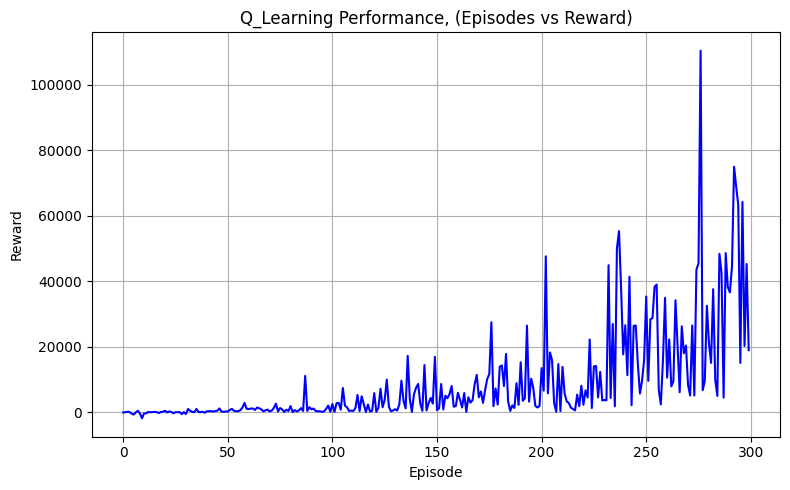

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps['Episode'], df_episode_steps['Reward'], color='blue')
plt.title('Q_Learning Performance, (Episodes vs Reward)')
plt.xlabel('Episode')
plt.ylabel('Reward')  
plt.grid(True)
plt.tight_layout()
plt.show()

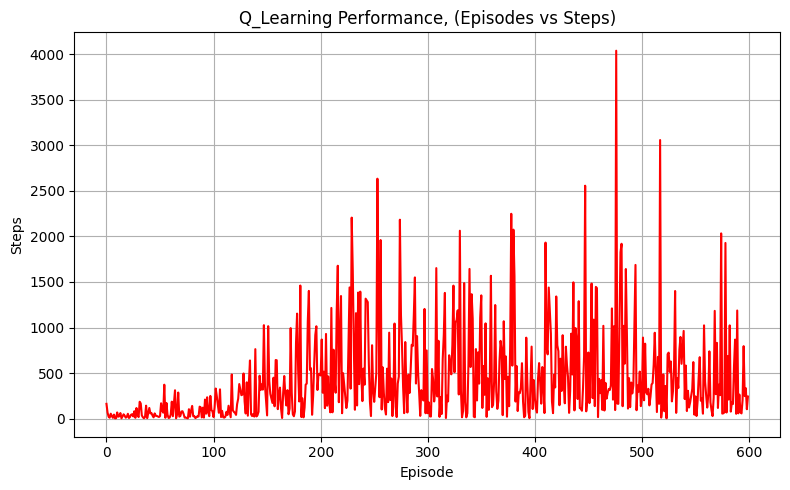

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_episode_steps['Episode'], df_episode_steps['Num_steps'], color='red')
plt.title('Q_Learning Performance, (Episodes vs Steps)')
plt.xlabel('Episode')
plt.ylabel('Steps')  
plt.grid(True)
plt.tight_layout()
plt.show()


#### Experiment with different gamma

In [ ]:
alpha=0.5
gamma=0.9
epsilon = 0.1
epsilon_decay=0.900
min_epsilon = 0.01
episodes=200
total_reward = 0
max_steps =500

if __name__ == "__main__":
    env = gridEnv()
    # Start with new environment
    state = env.reset()
    # Show the environment
    #env.render_2()
    # Vi
    q_table, total_reward, df_alpha9_gamma9 = q_learning(env,alpha, gamma, epsilon, epsilon_decay, min_epsilon, episodes, total_reward, max_steps)
    print()
    print(episodes)
    #print("Trained Q-Table:", q_table, '\n total reward: ', total_reward)
    print(q_table)
    

In [ ]:
df_alpha9_gamma9['Reward'][100:200]

In [ ]:
df_alpha9_gamma9['Num_steps']

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_alpha9_gamma9['Episode'], df_alpha9_gamma9['Reward'], color='blue')
plt.title('Q_Learning Performance, (Episodes vs Reward)')
plt.xlabel('Episode')
plt.ylabel('Reward')  
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(df_alpha9_gamma9['Episode'], df_alpha9_gamma9['Num_steps'], color='red')
plt.title('Q_Learning Performance, (Episodes vs Steps)')
plt.xlabel('Episode')
plt.ylabel('Steps')  
plt.grid(True)
plt.tight_layout()
plt.show()


## Pygame

In [ ]:
pip install pygame

In [ ]:
import pygame
import sys

# --- Settings ---
GRID_SIZE = 6
CELL_SIZE = 80
WIDTH, HEIGHT = GRID_SIZE * CELL_SIZE, GRID_SIZE * CELL_SIZE
FPS = 60

# Colors
WHITE = (255, 255, 255)
GRAY = (200, 200, 200)

# Initialize pygame
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Mario GridWorld")
clock = pygame.time.Clock()

# Load Mario icon
mario_img = pygame.image.load("mario.png")
mario_img = pygame.transform.scale(mario_img, (CELL_SIZE, CELL_SIZE))

# Agent's initial position
agent_pos = [0, 0]  # [row, col]

def draw_grid():
    for x in range(0, WIDTH, CELL_SIZE):
        for y in range(0, HEIGHT, CELL_SIZE):
            rect = pygame.Rect(x, y, CELL_SIZE, CELL_SIZE)
            pygame.draw.rect(screen, GRAY, rect, 1)

def draw_agent():
    row, col = agent_pos
    x = col * CELL_SIZE
    y = row * CELL_SIZE
    screen.blit(mario_img, (x, y))

# --- Game loop ---
running = True
while running:
    clock.tick(FPS)
    screen.fill(WHITE)

    # Handle events
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_UP and agent_pos[0] > 0:
                agent_pos[0] -= 1
            elif event.key == pygame.K_DOWN and agent_pos[0] < GRID_SIZE - 1:
                agent_pos[0] += 1
            elif event.key == pygame.K_LEFT and agent_pos[1] > 0:
                agent_pos[1] -= 1
            elif event.key == pygame.K_RIGHT and agent_pos[1] < GRID_SIZE - 1:
                agent_pos[1] += 1

    # Draw
    draw_grid()
    draw_agent()
    pygame.display.flip()

pygame.quit()
sys.exit()
